In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [2]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [3]:
df = pd.read_csv('/content/sample_data/potato_final.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [4]:
df = df.drop(['Temp'],axis=1)
df = df.drop(['Oil'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['Avg_Price'], axis=1)

df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

df.tail()

,Date,Rain,Wind,sobimul,nongmul,Price,Produced,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,2.5,8.7,415.0,549878,0,0,0,0
2391,2022-09-27,0.0,1.6,2.5,8.7,415.0,549878,1,0,0,0
2392,2022-09-28,0.0,1.8,2.5,8.7,415.0,549878,0,1,0,0
2393,2022-09-29,0.0,1.4,2.5,8.7,415.0,549878,0,0,1,0
2394,2022-09-30,0.0,1.6,2.5,8.7,415.0,549878,0,0,0,1


In [5]:
from sklearn.preprocessing import MinMaxScaler
input_indicator = df.loc[:,['Rain', 'Wind', 'sobimul', 'nongmul', 'Produced', 'W_1', 'W_2', 'W_3', 'W_4']]
target_indicator = df.loc[:,['Price']].values[:]

scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_input_indicator = scaler_input.fit_transform(input_indicator)
scaled_target_indicator = scaler_target.fit_transform(target_indicator) # 가격 관련 지표에 스케일링

x = np.concatenate((scaled_target_indicator, scaled_input_indicator), axis=1)
y = x[:, [0]]

print(x)
print(y.shape)

[[0.23348694 0.         0.61403509 ... 1.         0.         0.        ]
 [0.31029186 0.         0.36842105 ... 0.         1.         0.        ]
 [0.33794163 0.         0.19298246 ... 0.         0.         1.        ]
 ...
 [0.3640553  0.         0.19298246 ... 1.         0.         0.        ]
 [0.3640553  0.         0.12280702 ... 0.         1.         0.        ]
 [0.3640553  0.         0.15789474 ... 0.         0.         1.        ]]
(2395, 1)


In [6]:
# 21일치의 input으로 8일치의 output을 생산(API 문제상 당일날 input은 활용 불가능할 것으로 예상됨)
# 추후 train, validation, train set를 6년, 2년, 2년으로 나눠볼까 생각중, 지금은 many_to_many 코드 구현을 목표로 구현하지 않음
seq_length = 3
predict_day = 3
dataX = [] 
dataY = [] 
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] 
    dataX.append(_x) 
    dataY.append(_y) 
print(len(dataX))
print(len(dataY))

2389
2389


In [7]:
# Train Set 생성, 추후 Validation, Test도 여기에다가 추가 예상됨, 또한 21의 배수로 설정해야 batch에서 오류가 발생하지 않음
train_size = 1431
validation_size = 477
test_size = 477

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
validX = np.array(dataX[train_size:train_size+validation_size])
validY = np.array(dataY[train_size:train_size+validation_size])
testX = np.array(dataX[train_size+validation_size:train_size+validation_size+test_size])
testY = np.array(dataY[train_size+validation_size:train_size+validation_size+test_size])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1431, 3, 10)
(1431, 3, 1)
(477, 3, 10)
(477, 3, 1)
(477, 3, 10)
(477, 3, 1)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [9]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [116]:
input_columns = 10 # 데이터 셋의 '열' 개수 (dataX) / dataset's columns (dataX)

model = Sequential()
model.add(LSTM(16, batch_input_shape=(3, 3, input_columns), return_sequences=True, stateful=True, dropout=0.1))
model.add(LSTM(16, return_sequences=True, stateful=True, dropout=0.1))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (3, 3, 16)                1728      
                                                                 
 lstm_9 (LSTM)               (3, 3, 16)                2112      
                                                                 
 dense_4 (Dense)             (3, 3, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [117]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model-potato.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [118]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [119]:
custom_hist = CustomHistory()
custom_hist.init()

In [120]:
for epoch_idx in range(100):
  print('epochs:' + str(epoch_idx))
  hist = model.fit(trainX, trainY, validation_data=(validX, validY), epochs=1, batch_size=3, verbose=2, shuffle=False, callbacks=[checkpoint_cb, custom_hist, early_stopping_cb])
  model.reset_states()

epochs:0
477/477 - 5s - loss: 0.0282 - mae: 0.1239 - val_loss: 0.0234 - val_mae: 0.1418 - 5s/epoch - 11ms/step
epochs:1
477/477 - 2s - loss: 0.0253 - mae: 0.1176 - val_loss: 0.0214 - val_mae: 0.1367 - 2s/epoch - 5ms/step
epochs:2
477/477 - 2s - loss: 0.0191 - mae: 0.1025 - val_loss: 0.0137 - val_mae: 0.1081 - 2s/epoch - 4ms/step
epochs:3
477/477 - 2s - loss: 0.0135 - mae: 0.0846 - val_loss: 0.0058 - val_mae: 0.0622 - 2s/epoch - 4ms/step
epochs:4
477/477 - 2s - loss: 0.0092 - mae: 0.0666 - val_loss: 0.0040 - val_mae: 0.0513 - 2s/epoch - 5ms/step
epochs:5
477/477 - 2s - loss: 0.0090 - mae: 0.0651 - val_loss: 0.0044 - val_mae: 0.0563 - 2s/epoch - 4ms/step
epochs:6
477/477 - 2s - loss: 0.0089 - mae: 0.0647 - val_loss: 0.0036 - val_mae: 0.0461 - 2s/epoch - 5ms/step
epochs:7
477/477 - 2s - loss: 0.0074 - mae: 0.0587 - val_loss: 0.0028 - val_mae: 0.0381 - 2s/epoch - 5ms/step
epochs:8
477/477 - 2s - loss: 0.0075 - mae: 0.0588 - val_loss: 0.0033 - val_mae: 0.0421 - 2s/epoch - 5ms/step
epochs:9


In [121]:
a = 3

In [122]:
model.evaluate(trainX, trainY, batch_size = a)

477/477 [==============================] - 1s 3ms/step - loss: 0.0023 - mae: 0.0366


[0.0022998088970780373, 0.03658626973628998]

In [123]:
print(custom_hist.train_loss)

[0.02819283865392208, 0.025260571390390396, 0.019119100645184517, 0.01349223405122757, 0.009183692745864391, 0.00902301725000143, 0.008910635486245155, 0.007383089978247881, 0.007487600203603506, 0.006405207794159651, 0.0061059254221618176, 0.00629833061248064, 0.006121070124208927, 0.005772280972450972, 0.005777481012046337, 0.005692064296454191, 0.005461073014885187, 0.005056584719568491, 0.004899097140878439, 0.004794239532202482, 0.004854557104408741, 0.004533738829195499, 0.004467385821044445, 0.0040696668438613415, 0.004035437945276499, 0.0035790568217635155, 0.0033933937083929777, 0.0034336100798100233, 0.0032003677915781736, 0.003109181299805641, 0.0028466389048844576, 0.003414897248148918, 0.0030178360175341368, 0.002490191487595439, 0.002550212200731039, 0.0024455387610942125, 0.002995341783389449, 0.0026747051160782576, 0.002541771624237299, 0.0022778594866394997, 0.0023181471042335033, 0.0023349106777459383, 0.002301351400092244, 0.0025406733620911837, 0.002697539981454611,

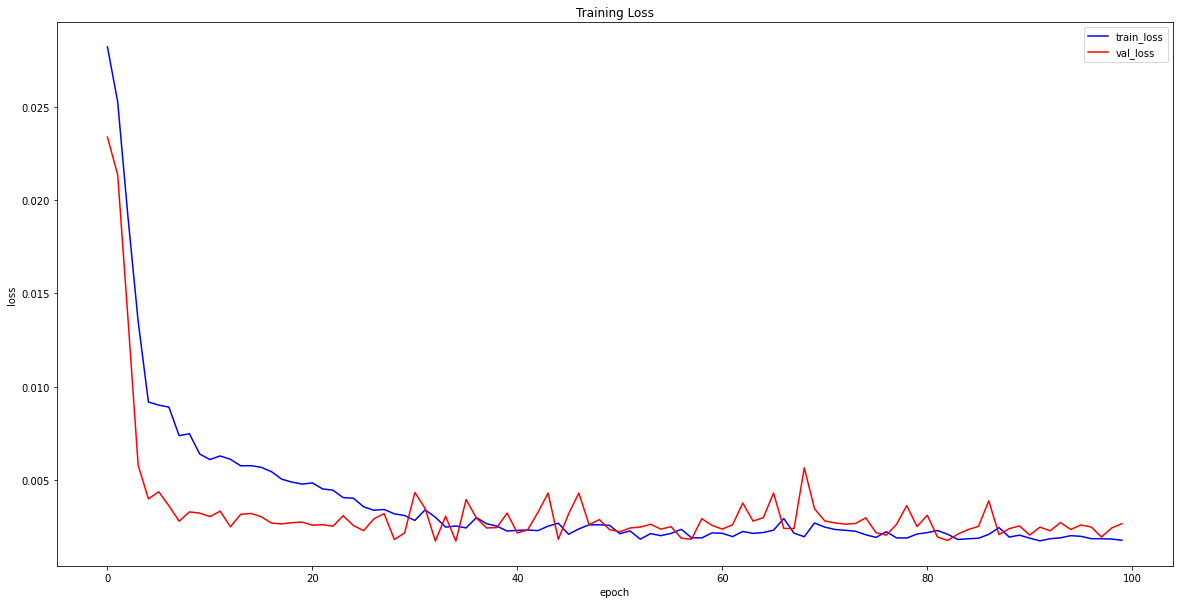

In [124]:
plt.figure(figsize=(20,10))
plt.plot(custom_hist.train_loss, color = 'blue', label = 'train_loss')
plt.plot(custom_hist.val_loss, color = 'red', label = 'val_loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [125]:
from keras.models import load_model
model = load_model('/content/best-model-potato.h5')

Train Data *평가*

In [126]:
model.evaluate(trainX, trainY, batch_size=a)

477/477 [==============================] - 2s 3ms/step - loss: 0.0024 - mae: 0.0326


[0.0023502917028963566, 0.032571204006671906]

In [127]:
predicted_price_train = model.predict(trainX, batch_size=a, verbose=1) 

477/477 [==============================] - 2s 2ms/step


In [128]:
trainY_test = np.delete(trainY, np.s_[1:a], axis=1)
predicted_price_train_test = np.delete(predicted_price_train, np.s_[1:a], axis=1)

trainY_test = np.reshape(trainY_test, (1431, 1))
predicted_price_train_test = np.reshape(predicted_price_train_test, (1431, 1))
print(trainY_test.shape)
print(predicted_price_train_test.shape)

(1431, 1)
(1431, 1)


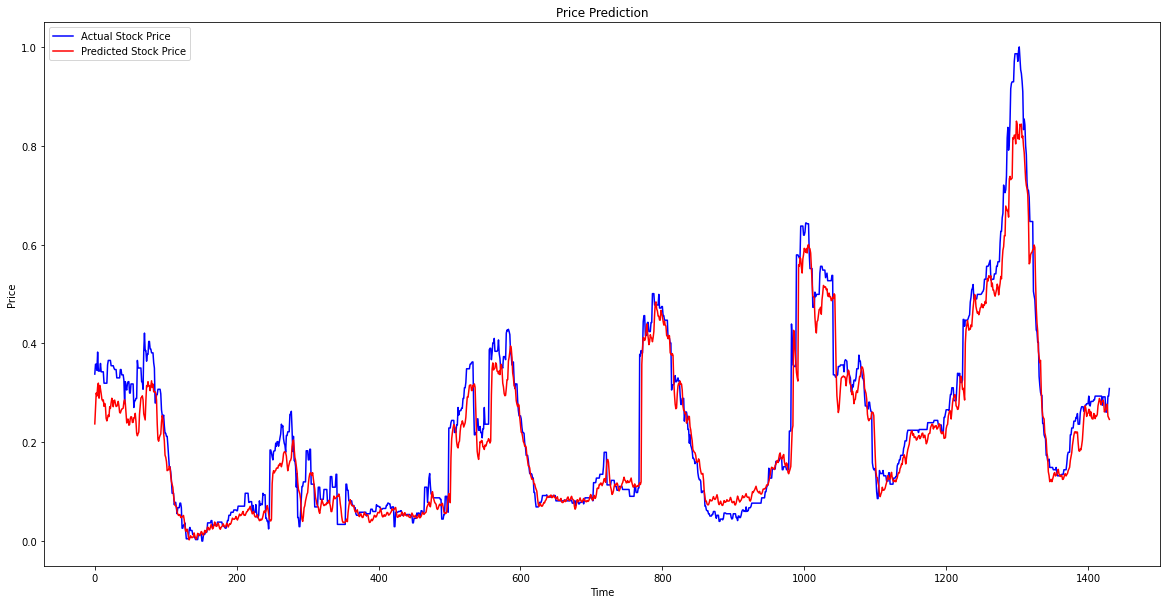

In [129]:
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [130]:
predicted_price_train_test = np.reshape(predicted_price_train_test, (1431, ))
predicted_price_train_test = scaler_target.inverse_transform(predicted_price_train_test.reshape(-1,1))

print(predicted_price_train_test, predicted_price_train_test.shape)

trainY_test = scaler_target.inverse_transform(trainY_test.reshape(-1,1))

print(trainY_test, trainY_test.shape)

[[332.40027]
 [352.7503 ]
 [373.03156]
 ...
 [342.63983]
 [340.35776]
 [338.31845]] (1431, 1)
[[398.]
 [411.]
 [411.]
 ...
 [369.]
 [369.]
 [379.]] (1431, 1)


In [131]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(trainY_test, predicted_price_train_test) 
np.sqrt(MSE)

31.44375047810387

In [132]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(trainY_test, predicted_price_train_test)

21.140672940961306

Val Date 평가


In [133]:
model.evaluate(validX, validY, batch_size=a)

159/159 [==============================] - 0s 3ms/step - loss: 0.0017 - mae: 0.0289


[0.0017399213975295424, 0.02889532968401909]

In [134]:
predicted_price_valid = model.predict(validX, batch_size=a, verbose=1) 

159/159 [==============================] - 0s 2ms/step


(477, 1)
(477, 1)


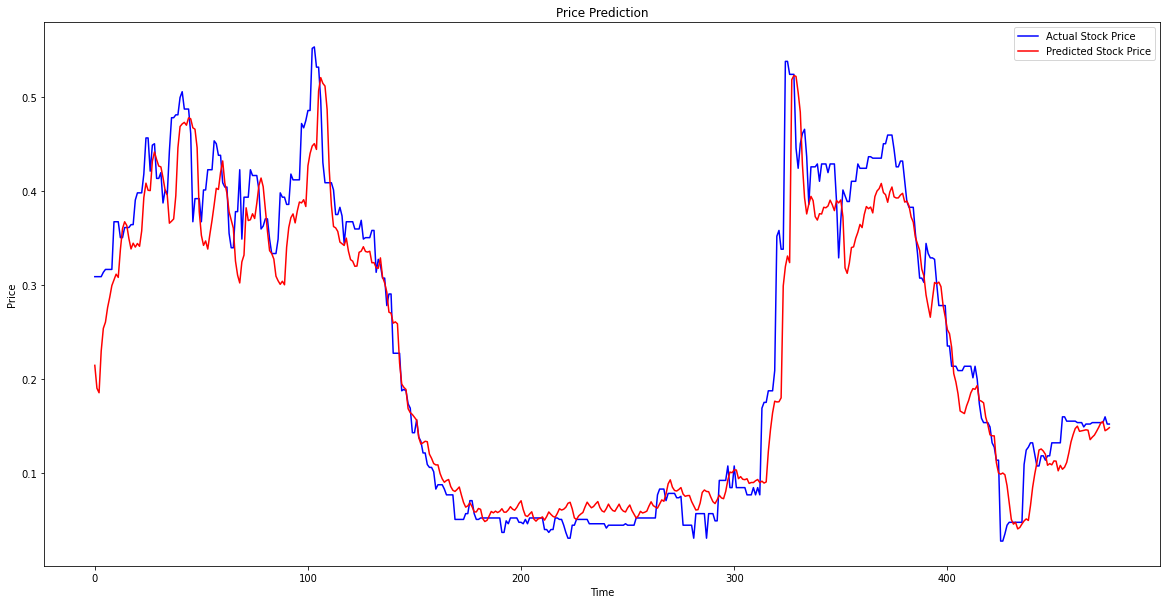

In [135]:
validY_test = np.delete(validY, np.s_[1:a], axis=1)
predicted_price_valid_test = np.delete(predicted_price_valid, np.s_[1:a], axis=1)

validY_test = np.reshape(validY_test, (477, 1))
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (477, 1))
print(validY_test.shape)
print(predicted_price_valid_test.shape)

plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [136]:
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (477, ))
predicted_price_valid_test = scaler_target.inverse_transform(predicted_price_valid_test.reshape(-1,1))

print(predicted_price_valid_test, predicted_price_valid_test.shape)

validY_test = scaler_target.inverse_transform(validY_test.reshape(-1,1))

print(validY_test, validY_test.shape)

[[317.62317]
 [301.76785]
 [298.65936]
 [327.52   ]
 [343.1876 ]
 [347.52585]
 [357.5701 ]
 [364.73032]
 [372.8234 ]
 [376.8694 ]
 [380.70877]
 [378.4956 ]
 [397.63962]
 [412.21973]
 [416.99686]
 [414.45575]
 [405.32047]
 [398.18347]
 [402.16287]
 [399.4566 ]
 [401.9539 ]
 [400.013  ]
 [410.65945]
 [433.7207 ]
 [443.705  ]
 [438.77557]
 [438.5734 ]
 [458.9278 ]
 [465.29767]
 [460.02274]
 [455.53546]
 [454.98105]
 [447.51404]
 [438.6963 ]
 [435.36163]
 [416.00888]
 [417.36185]
 [418.93958]
 [434.92844]
 [468.23343]
 [482.89777]
 [484.6971 ]
 [485.76465]
 [483.82355]
 [488.88776]
 [488.2488 ]
 [482.02997]
 [481.0666 ]
 [468.30814]
 [423.99872]
 [407.62662]
 [400.6541 ]
 [403.7255 ]
 [398.10242]
 [408.398  ]
 [417.95746]
 [428.70496]
 [440.15143]
 [439.34476]
 [451.11957]
 [459.0833 ]
 [443.80188]
 [436.62698]
 [423.8441 ]
 [418.16852]
 [412.59915]
 [389.80682]
 [379.9952 ]
 [374.65207]
 [389.22775]
 [393.9242 ]
 [426.65958]
 [417.84985]
 [418.37778]
 [422.5173 ]
 [419.2537 ]
 [429.70395]

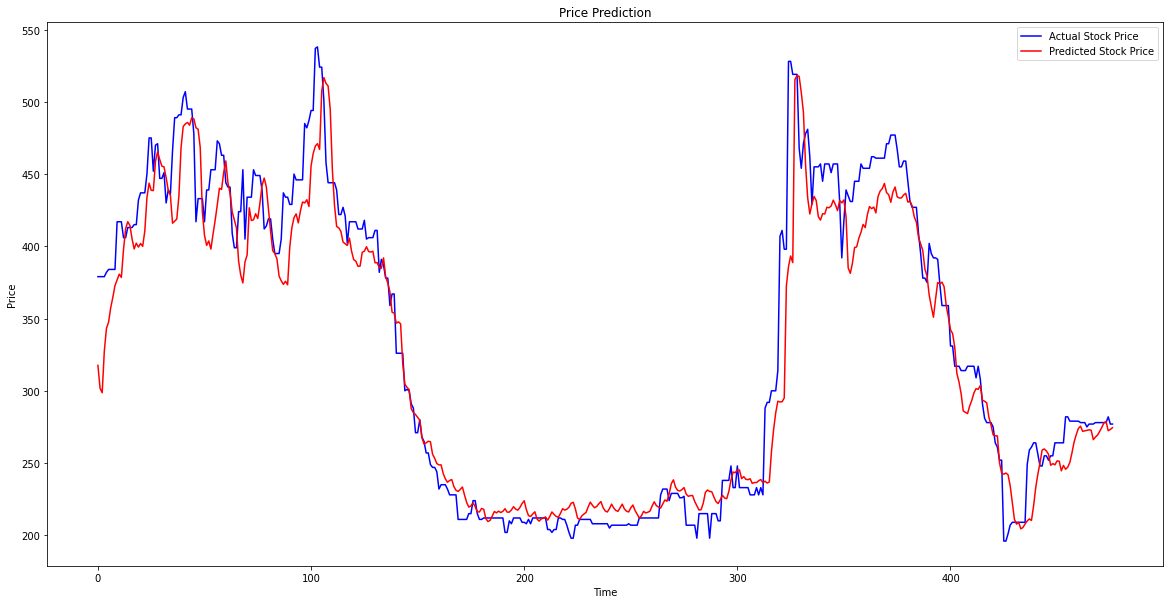

In [137]:
plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [138]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(validY_test, predicted_price_valid_test) 
np.sqrt(MSE)

27.79469082589442

In [139]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validY_test, predicted_price_valid_test)

19.222035981824064

Test Data 평가

In [140]:
model.evaluate(testX, testY, batch_size=a)

159/159 [==============================] - 0s 3ms/step - loss: 0.0053 - mae: 0.0488


[0.005295122507959604, 0.04879222810268402]

In [141]:
predicted_price_test = model.predict(testX, batch_size=a, verbose=1)

159/159 [==============================] - 0s 2ms/step


(477, 1)
(477, 1)


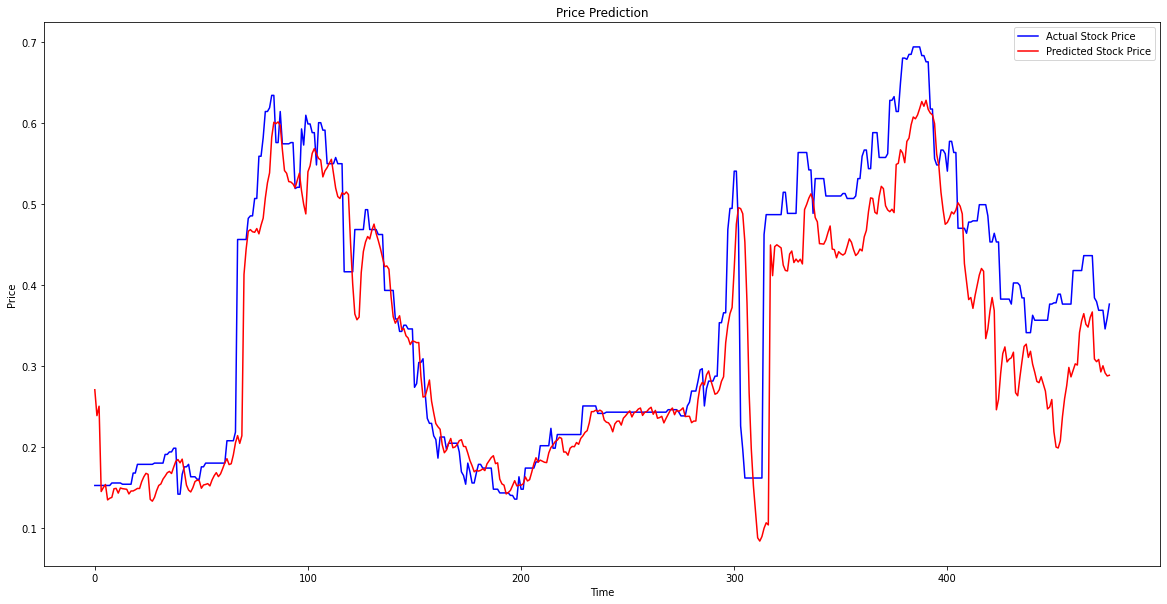

In [142]:
testY_test = np.delete(testY, np.s_[1:a], axis=1)
predicted_price_test_test = np.delete(predicted_price_test, np.s_[1:a], axis=1)

testY_test = np.reshape(testY_test, (477, 1))
predicted_price_test_test = np.reshape(predicted_price_test_test, (477, 1))
print(testY_test.shape)
print(predicted_price_test_test.shape)

plt.figure(figsize=(20,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [143]:
predicted_price_test_test = np.reshape(predicted_price_test_test, (477, ))
predicted_price_test_test = scaler_target.inverse_transform(predicted_price_test_test.reshape(-1,1))

print(predicted_price_test_test, predicted_price_test_test.shape)

testY_test = scaler_target.inverse_transform(testY_test.reshape(-1,1))

print(testY_test, testY_test.shape)

[[354.0347 ]
 [333.20477]
 [340.80524]
 [272.12448]
 [275.2773 ]
 [277.79315]
 [265.3662 ]
 [266.7038 ]
 [267.40765]
 [274.36832]
 [274.67032]
 [270.85837]
 [274.9943 ]
 [274.43912]
 [274.2238 ]
 [273.92267]
 [270.15912]
 [272.5609 ]
 [272.59396]
 [273.5259 ]
 [274.60577]
 [274.55975]
 [280.09058]
 [283.9777 ]
 [286.7687 ]
 [285.95724]
 [265.84427]
 [264.36386]
 [267.39758]
 [272.81027]
 [277.0203 ]
 [278.21735]
 [282.11575]
 [284.52536]
 [287.24774]
 [288.30536]
 [286.6269 ]
 [291.70245]
 [296.4089 ]
 [297.8771 ]
 [295.20517]
 [298.19922]
 [288.13953]
 [277.29245]
 [273.30615]
 [271.78268]
 [275.1816 ]
 [280.1121 ]
 [281.28848]
 [280.87997]
 [274.78207]
 [277.38272]
 [277.84702]
 [278.4732 ]
 [276.65427]
 [281.3883 ]
 [284.83008]
 [287.329  ]
 [284.1286 ]
 [286.34464]
 [290.6306 ]
 [295.2047 ]
 [298.5609 ]
 [293.8097 ]
 [294.4791 ]
 [301.6028 ]
 [311.34326]
 [317.15387]
 [310.85886]
 [317.0277 ]
 [446.87457]
 [467.24423]
 [481.61368]
 [482.93027]
 [481.22745]
 [480.78302]
 [483.7998 ]

In [144]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(testY_test, predicted_price_test_test) 
np.sqrt(MSE)

47.605911486538275

In [145]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testY_test, predicted_price_test_test)

32.03958696089452

예측방법

In [146]:
minX1 = np.array(dataX[0:3])
minX2 = np.array(dataX[0:4])
minX3 = np.array(dataX[0:2385])
minX4 = np.array(dataX[0:train_size])

In [147]:
predicted_price_min1 = model.predict(minX1, batch_size=a, verbose=1)
predicted_price_min2 = model.predict(minX2, batch_size=a, verbose=1) 
predicted_price_min3 = model.predict(minX3, batch_size=a, verbose=1)
predicted_price_min4 = model.predict(minX4, batch_size=a, verbose=1) 

477/477 [==============================] - 1s 2ms/step


In [148]:
predicted_price_min1[0]

array([[0.2754854 ],
       [0.24347812],
       [0.25573987]], dtype=float32)

In [149]:
predicted_price_min2[0]

array([[0.24584346],
       [0.22999145],
       [0.2529075 ]], dtype=float32)

In [150]:
predicted_price_min3[0]

array([[0.26586154],
       [0.2471802 ],
       [0.2621799 ]], dtype=float32)

In [151]:
scaler_target.inverse_transform(predicted_price_min4[0].reshape(-1,1))

array([[357.341  ],
       [336.50427],
       [344.48666]], dtype=float32)